In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import Matrix
from multiple_stabilizers import get_condition_indices, generate_parity_check_matrix
from ldpc import BpOsdDecoder
import ldpc.code_util

def simulate_BpOsd_decoder_performance(H, L, m, stabilizer_shape, num_trials=1000, error_range=(0.01, 0.4), num_points=50, bp_method="minimum_sum", osd_method="OSD_0", osd_order=0, bp_max_iter=0, ms_scaling_factor=0.0):
    n = H * L
    if bp_max_iter == 0:
        bp_max_iter = n  # Default maximum number of iterations for BP decoder
    condition_indices = get_condition_indices(stabilizer_shape)
    H_matrix = generate_parity_check_matrix(H, L, m, condition_indices)
    codeword = np.zeros((H_matrix.shape[1],), dtype=int) # all zeros codeword

    error_rates = np.linspace(error_range[0], error_range[1], num_points).astype(float)
    decoding_success_rates = []
    logical_error_rates = []
    decoding_failure_rates = []

    for error_rate in error_rates:
        logical_errors = 0
        decoding_successes = 0
        decoding_failures = 0

        bpd = BpOsdDecoder(
            H_matrix, # the parity check matrix
            error_rate=float(error_rate), # physical error rate for the BP decoder
            max_iter=bp_max_iter, # the maximum number of iterations for BP
            bp_method=bp_method, # 'minimum_sum' or 'sum_product'
            ms_scaling_factor=ms_scaling_factor, # min sum scaling factor. If set to zero the variable scaling factor method is used
            osd_method=osd_method,  # 'OSD_0', 'OSD_CS', 'OSD_E'
            osd_order=osd_order # order of the OSD method
        )

        for _ in range(num_trials):
            error = (np.random.rand(len(codeword)) < error_rate).astype(int)
            received = (codeword + error) % 2
            syndrome = np.mod(H_matrix @ received, 2)
            expected_error = bpd.decode(syndrome)
            residual_error = (expected_error + error) % 2
            check_syndrome = np.mod(H_matrix @ expected_error, 2)

            if np.array_equal(check_syndrome, syndrome):
                if np.array_equal(expected_error, error):
                    decoding_successes += 1
                else:
                    logical_errors += 1
            else:
                decoding_failures += 1

        decoding_success_rates.append(decoding_successes / num_trials)
        decoding_failure_rates.append(decoding_failures / num_trials)
        logical_error_rates.append(logical_errors / num_trials)

    return error_rates, decoding_success_rates, logical_error_rates, decoding_failure_rates


In [2]:
import numpy as np
import ldpc.codes


stabilizer_shape = np.array([[0, 1, 0],
                             [0, 1, 0],
                             [1, 0, 1]])



H = 8
L = 17
m = 3

error_rates, decoding_success_rates_osd_0, logical_error_rates_osd_0, decoding_failure_rates_osd_0 = simulate_BpOsd_decoder_performance(
    H, L, m, stabilizer_shape, num_trials=1000, error_range=(0.01, 0.4), num_points=50, bp_method="minimum_sum", osd_method="OSD_0", osd_order=0
)

# OSD higher order
error_rates_osd, decoding_success_rates_osd_cs, logical_error_rates_osd_cs, decoding_failure_rates_osd_cs = simulate_BpOsd_decoder_performance(
    H, L, m, stabilizer_shape, num_trials=1000, error_range=(0.01, 0.4), num_points=50, bp_method="minimum_sum", osd_method="OSD_CS", osd_order=2
)



Stabilizer shape:
[[0 1 0]
 [0 1 0]
 [1 0 1]]
Stabilizer shape:
[[0 1 0]
 [0 1 0]
 [1 0 1]]


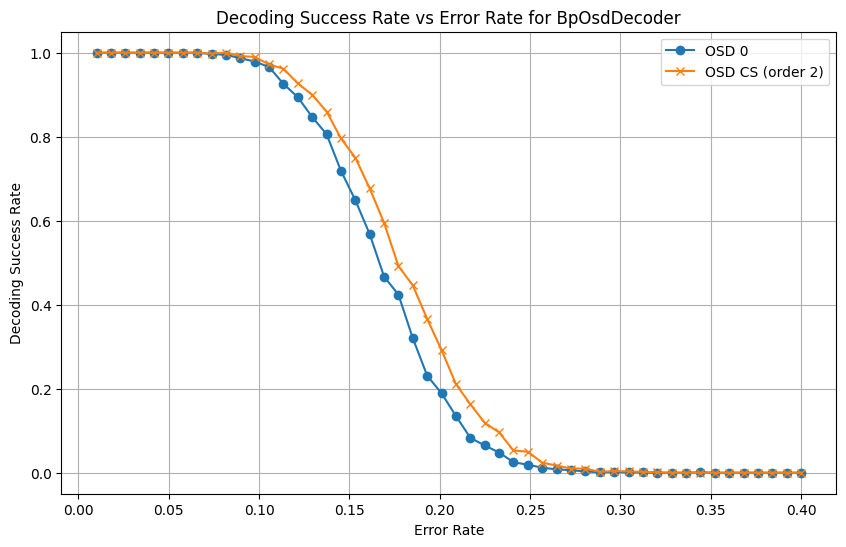

In [3]:
# Plotting the results (only success rates)
plt.figure(figsize=(10, 6))
plt.plot(error_rates, decoding_success_rates_osd_0, label='OSD 0', marker='o')
plt.plot(error_rates_osd, decoding_success_rates_osd_cs, label='OSD CS (order 2)', marker='x')
plt.xlabel('Error Rate')
plt.ylabel('Decoding Success Rate')
plt.title('Decoding Success Rate vs Error Rate for BpOsdDecoder')
plt.legend()
plt.grid()
plt.show()

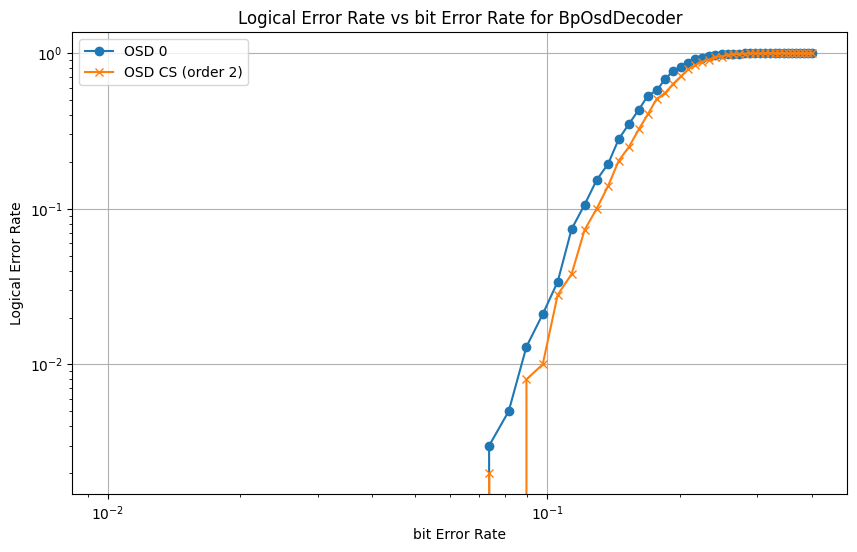

In [4]:
# Plotting the results (only logical-error rates)
plt.figure(figsize=(10, 6))
plt.plot(error_rates, logical_error_rates_osd_0, label='OSD 0', marker='o')
plt.plot(error_rates_osd, logical_error_rates_osd_cs, label='OSD CS (order 2)', marker='x')
plt.xlabel('bit Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Logical Error Rate vs bit Error Rate for BpOsdDecoder')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [3]:
import numpy as np
from itertools import combinations

stabilizer_shape = np.array([[0, 1, 0],
                             [1, 1, 1],
                             [0, 0, 0]])

m = 2

max_iter_list = [4, 1032, 5247, 10000, 11365]
logical_rates_list = []

for max_iter in max_iter_list:
    print(f"Simulating with max_iter = {max_iter}")
    
    # Simulate decoder performance for each shape
    error_rates, success_rates, logical_rates, failure_rates = simulate_BpOsd_decoder_performance(
        H=3,
        L=10,
        m=m,
        stabilizer_shape=stabilizer_shape,
        num_trials=10000,
        error_range=(0.001, 0.05),
        num_points=12,
        bp_max_iter=max_iter,
        bp_method="minimum_sum",
        osd_method="OSD_CS",
        osd_order=10,
        ms_scaling_factor=0.625
    )
    print(f"Max Iter: {max_iter}, Logical Rates: {logical_rates}")
    logical_rates_list.append(logical_rates)



Simulating with max_iter = 4
Stabilizer shape:
[[0 1 0]
 [1 1 1]
 [0 0 0]]
Max Iter: 4, Logical Rates: [0.0, 0.0, 0.0, 0.0, 0.0004, 0.0001, 0.0007, 0.0004, 0.0008, 0.0022, 0.0033, 0.0039]
Simulating with max_iter = 1032
Stabilizer shape:
[[0 1 0]
 [1 1 1]
 [0 0 0]]
Max Iter: 1032, Logical Rates: [0.0, 0.0, 0.0, 0.0, 0.0001, 0.0001, 0.0001, 0.0009, 0.0015, 0.0029, 0.0031, 0.0047]
Simulating with max_iter = 5247
Stabilizer shape:
[[0 1 0]
 [1 1 1]
 [0 0 0]]
Max Iter: 5247, Logical Rates: [0.0, 0.0, 0.0001, 0.0001, 0.0003, 0.0004, 0.0003, 0.0009, 0.0009, 0.0013, 0.0029, 0.0043]
Simulating with max_iter = 10000
Stabilizer shape:
[[0 1 0]
 [1 1 1]
 [0 0 0]]
Max Iter: 10000, Logical Rates: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0002, 0.0003, 0.001, 0.0015, 0.0013, 0.0022, 0.0046]
Simulating with max_iter = 11365
Stabilizer shape:
[[0 1 0]
 [1 1 1]
 [0 0 0]]
Max Iter: 11365, Logical Rates: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0001, 0.0009, 0.0008, 0.0017, 0.0037, 0.0044]


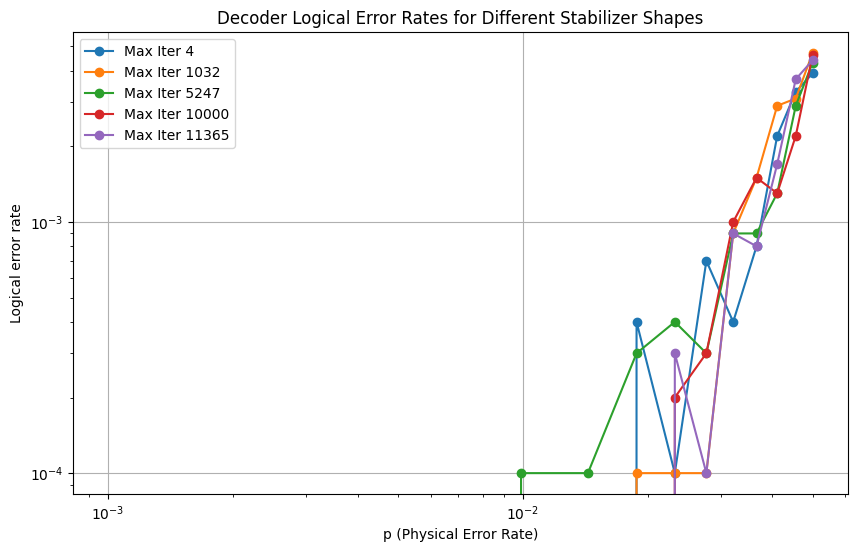

In [ ]:
plt.figure(figsize=(10, 6))
for max_iter, logical_rates in zip(max_iter_list, logical_rates_list):
    plt.plot(error_rates, logical_rates, label=f'Max Iter {max_iter}', marker='o')
    plt.legend([f'Max Iter {mi}' for mi in max_iter_list])
plt.xlabel('p (Physical Error Rate)')
plt.ylabel('Logical error rate')
plt.title('Decoder Logical Error Rates for Different Number of Maximum Iteration')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

# plt.plot(error_rates, logical_rates, label=f'Max Iter {max_iter}', marker='o')